## 클래스 합침

In [51]:
import pandas as pd
import numpy as np
import sklearn
import seaborn
import matplotlib.pyplot as plt

In [52]:
wash_data = pd.read_csv('./wash.csv', header=None)
brush_data = pd.read_csv('./brush.csv', header=None)
eat_data = pd.read_csv('./eat.csv', header=None)
dummy_data = pd.read_csv('./dummy.csv', header=None)
sit_stand_data = pd.read_csv('./sit_stand.csv', header=None)
walk_data = pd.read_csv('./walk.csv', header=None)

In [53]:
dummy_data[16] = 0
wash_data[16] = 1
brush_data[16] = 2
eat_data[16] = 3
sit_stand_data[16] = 4
walk_data[16] = 5

dummy_arr = dummy_data.to_numpy()
wash_arr = wash_data.to_numpy()
brush_arr = brush_data.to_numpy()
eat_arr = eat_data.to_numpy()
sit_stand_arr = sit_stand_data.to_numpy()
walk_arr = walk_data.to_numpy()

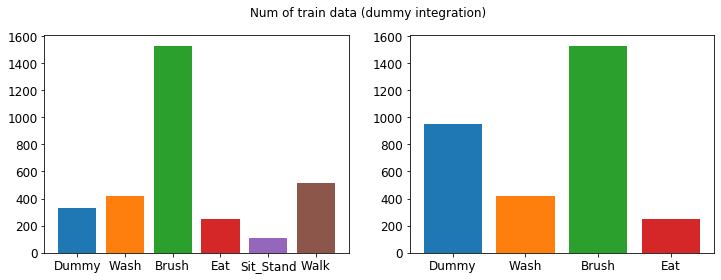

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(0, len(dummy_arr))
plt.bar(1, len(wash_arr))
plt.bar(2, len(brush_arr))
plt.bar(3, len(eat_arr))
plt.bar(4, len(sit_stand_arr))
plt.bar(5, len(walk_arr))

plt.xticks((0, 1, 2, 3, 4, 5), ('Dummy', 'Wash', 'Brush', 'Eat', 'Sit_Stand', 'Walk'))
plt.suptitle('Num of train data')


plt.subplot(1, 2, 2)
plt.bar(0, len(dummy_arr) + len(sit_stand_arr) + len(walk_arr))
plt.bar(1, len(wash_arr))
plt.bar(2, len(brush_arr))
plt.bar(3, len(eat_arr))

plt.xticks((0, 1, 2, 3), ('Dummy', 'Wash', 'Brush', 'Eat'))
plt.suptitle('Num of train data (dummy integration)')

plt.show() 

In [55]:
sit_stand_data[16] = 0 # dummy label
walk_data[16] = 0 # dummy label
dummy_arr = np.concatenate((dummy_arr, sit_stand_data.to_numpy(), walk_data.to_numpy()))

In [56]:
sampled_dummy = sklearn.utils.resample(dummy_arr, n_samples = 400, random_state = 42)
sampled_wash = sklearn.utils.resample(wash_arr, n_samples = 400, random_state = 42)
sampled_brush = sklearn.utils.resample(brush_arr, n_samples = 400, random_state = 42)
sampled_eat = sklearn.utils.resample(eat_arr, n_samples = 400, random_state = 42)

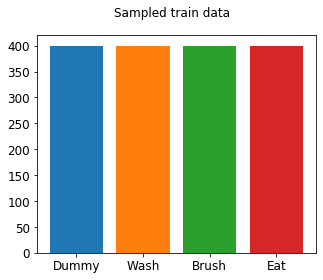

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.bar(0, len(sampled_dummy))
plt.bar(1, len(sampled_wash))
plt.bar(2, len(sampled_brush))
plt.bar(3, len(sampled_eat))

plt.xticks((0, 1, 2, 3), ('Dummy', 'Wash', 'Brush', 'Eat'))
plt.suptitle('Sampled train data')
plt.show() 

In [58]:
tot_data = np.concatenate((sampled_dummy, sampled_wash, sampled_brush, sampled_eat))
train_x = tot_data[:,:-1]
train_y = tot_data[:,-1:]

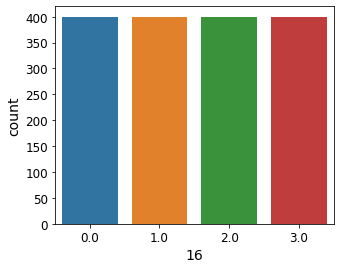

In [59]:
import seaborn as sns
plt.figure(figsize=(5, 4))
df = pd.DataFrame(tot_data)
sns.countplot(x = 16, data = df)

# visualization

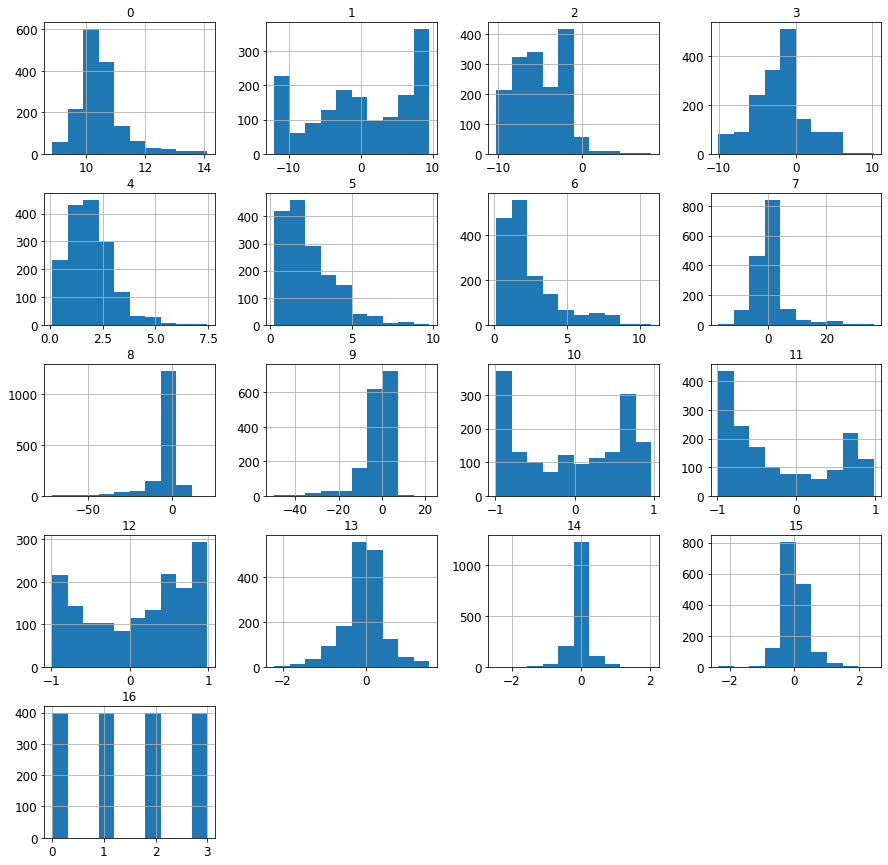

In [60]:
df[df.columns].hist(figsize=(15, 15))
plt.show()

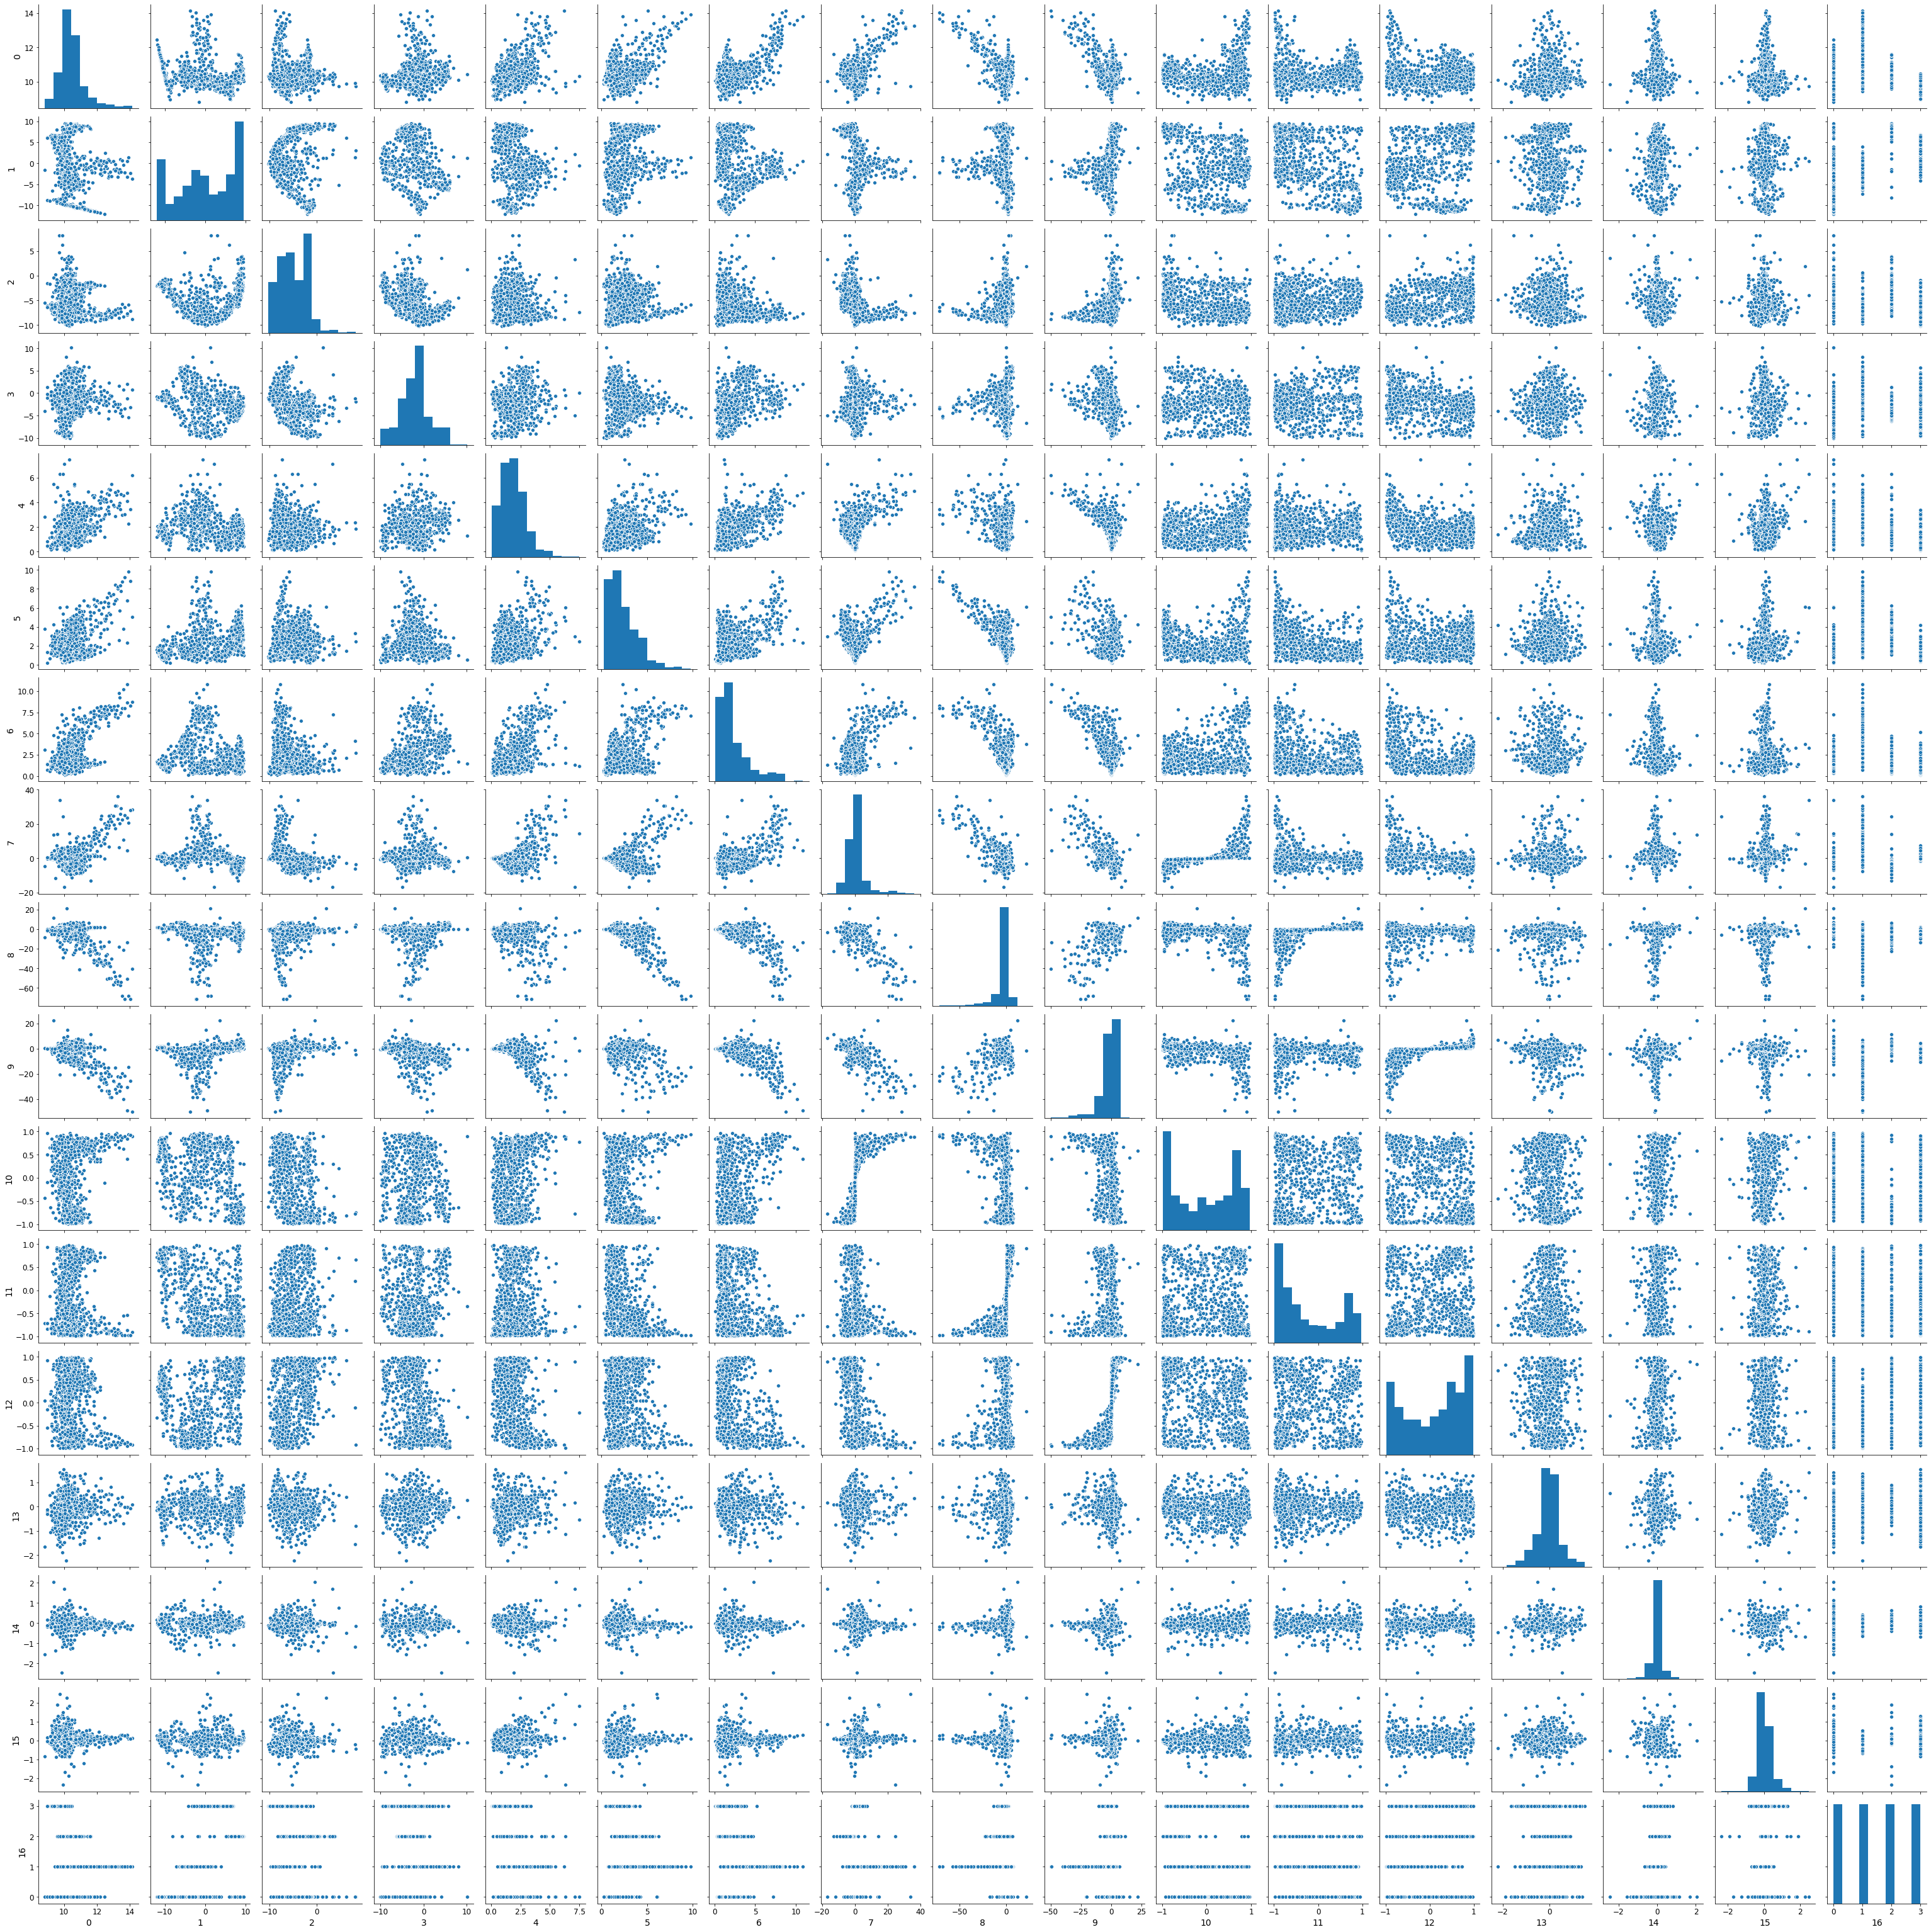

In [61]:
sns.pairplot(df)

# train

In [80]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svm_clf_ = SVC(random_state=42, gamma = 0.01)
scores = cross_val_score(svm_clf_, train_x, train_y.flatten(), cv=skf)

In [82]:
print(scores)

[0.925   0.9625  0.95    0.91875 0.96875 0.9625  0.95    0.94375 0.95625
 0.95625]


In [83]:
round(np.mean(scores), 2)

0.95

In [84]:
from sklearn.model_selection import cross_val_predict
svm_clf = SVC(random_state=42, gamma = 0.01)
y_train_pred = cross_val_predict(svm_clf, train_x, train_y.flatten(), cv=skf)

In [85]:
class_names = ['dummy', 'wash', 'brush', 'eat']

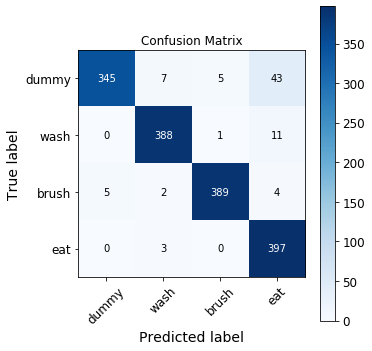

In [86]:
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_y.flatten(), y_train_pred)


plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

thresh = cm.max() / 2.
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center', color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [69]:
from sklearn.svm import SVC
from micromlgen import port
svm_clf = SVC(random_state=42, gamma = 0.01).fit(train_x, train_y.flatten())
print(port(svm_clf))

#pragma once
/**
 * Compute kernel between feature vector and support vector.
 * Kernel type: rbf
 */
double compute_kernel(double x[16], ...) {
    va_list w;
    double kernel = 0.0;
    va_start(w, 16);
    for (uint16_t i = 0; i < 16; i++)
            kernel += pow(x[i] -  va_arg(w, double) , 2);
        kernel = exp(-0.01 * kernel);
    return kernel;
}
/**
 * Predict class for features vector
 */
int predict(double *x) {
    double kernels[373] = { 0 };
    double decisions[6] = { 0 };
    int votes[4] = { 0 };
        kernels[0] = compute_kernel(x,   9.93  , -7.43  , -3.72  , -3.05  , 3.78  , 2.78  , 2.73  , 2.48  , 2.72  , -6.2  , 0.24  , 0.36  , -0.6  , 0.18  , -0.8  , 0.52 );
        kernels[1] = compute_kernel(x,   9.57  , 7.99  , -4.65  , 1.22  , 1.27  , 1.09  , 1.57  , 1.08  , 1.45  , 1.85  , 0.78  , 0.85  , 0.93  , 0.64  , 0.1  , -0.56 );
        kernels[2] = compute_kernel(x,   9.48  , -5.21  , 0.24  , -6.07  , 4.06  , 3.32  , 1.43  , -11.74  , 0.97  , -0.19  , -0.87  , 

# Standard Scaling

In [71]:
mean = np.mean(train_x)
std = np.std(train_x)

scaled_train_x = train_x - mean
scaled_train_x /= std

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svm_clf_ = SVC(random_state=42, gamma = 0.01)
scores = cross_val_score(svm_clf_, scaled_train_x, train_y.flatten(), cv=skf)

In [73]:
print(f"10 fold score: {scores}")
print(f"10 fold score mean: {np.mean(scores)}")

10 fold score: [0.88125 0.95    0.875   0.8875  0.925   0.9375  0.95    0.90625 0.95
 0.925  ]
10 fold score mean: 0.91875


In [74]:
from sklearn.model_selection import cross_val_predict
svm_clf = SVC(random_state=42, gamma = 0.01)
y_train_pred = cross_val_predict(svm_clf, scaled_train_x, train_y.flatten(), cv=skf)

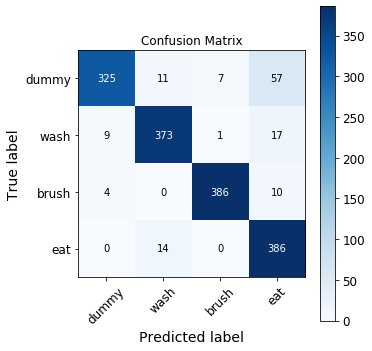

In [76]:
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
scaled_cm = confusion_matrix(train_y.flatten(), y_train_pred)


plt.imshow(scaled_cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

thresh = cm.max() / 2.
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center', color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

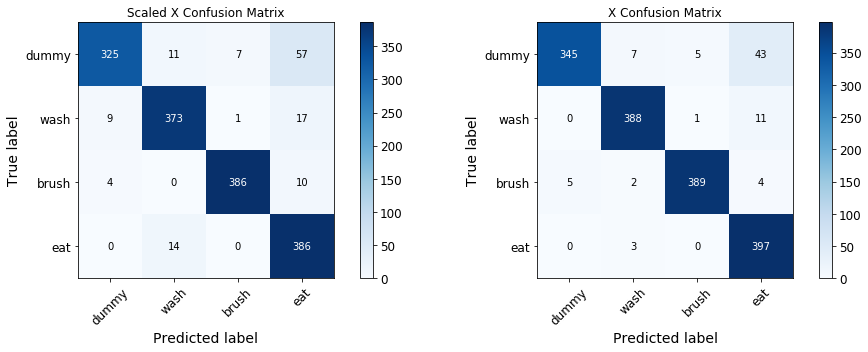

In [90]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(scaled_cm, interpolation='nearest', cmap='Blues')
plt.title("Scaled X Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

thresh = scaled_cm.max() / 2.
for (i, j), z in np.ndenumerate(scaled_cm):
    plt.text(j, i, z, ha='center', va='center', color="white" if scaled_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("X Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

thresh = cm.max() / 2.
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center', color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 이렇게 구데기가 된 이유??  스케일링을 했더니 feature 영향이 사라짐 ?